### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

In [2]:
def chart(x,y,name):
    fig.add_trace(go.Scatter(x=x, y=y,mode='lines', name=name))
    return chart

In [3]:
# Define slider function for charts
def slider(x):
    x.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(count=10, label="10y", step="year", stepmode="backward"),
                dict(count=15, label="15y", step="year", stepmode="backward"),
                dict(count=25, label="25y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return slider

#### Read the file from the saved location

#### - Qtrly data

In [4]:
df_qtr=pd.read_csv('./Data/Qtr_US.csv',parse_dates=['Date'],index_col='Date').drop('Unnamed: 0',axis=1)

In [5]:
df_qtr.tail()

PMI        NMI  Consumer_sen  building_permits  \
Date                                                               
2019-06-30  52.433333  55.833333     98.466667       1313.666667   
2019-09-30  49.433333  54.400000     93.800000       1424.666667   
2019-12-31  48.133333  54.400000     97.200000       1490.000000   
2020-03-31  50.033333  55.100000     96.633333       1443.333333   
2020-06-30  42.300000  43.600000     71.800000       1143.000000   

            Unemployment       Non_Farm  Initial_Claims  Continuing_Claims  \
Date                                                                         
2019-06-30   5924.333333  150609.333333    2.184615e+05       1.685231e+06   
2019-09-30   5926.333333  151160.333333    2.144615e+05       1.688462e+06   
2019-12-31   5807.000000  151788.333333    2.183077e+05       1.706154e+06   
2020-03-31   6273.000000  151921.666667    9.673077e+05       2.266231e+06   
2020-06-30  22031.500000  131657.500000    3.233091e+06       1.988400e+07   

                 SnP500        VIX  Net_Export  int_spread   Real_GDP  
Date                                                                   
2019-06-30  2882.327778  15.183016    -662.660   -0.063333  19021.860  
2019-09-30  2957.836406  15.960156    -653.032   -0.393333  19121.112  
2019-12-31  3082.755625  13.985781    -577.867    0.150000  19221.970  
2020-03-31  3055.869194  31.224516    -526.154    0.123333  18974.702  
2020-06-30  2916.986491  34.714561         NaN    0.615000        NaN

#### Analysis on qtrly data

In [6]:
df_qtr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 289 entries, 1948-06-30 to 2020-06-30
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PMI                289 non-null    float64
 1   NMI                91 non-null     float64
 2   Consumer_sen       252 non-null    float64
 3   building_permits   241 non-null    float64
 4   Unemployment       289 non-null    float64
 5   Non_Farm           289 non-null    float64
 6   Initial_Claims     213 non-null    float64
 7   Continuing_Claims  213 non-null    float64
 8   SnP500             289 non-null    float64
 9   VIX                121 non-null    float64
 10  Net_Export         288 non-null    float64
 11  int_spread         263 non-null    float64
 12  Real_GDP           288 non-null    float64
dtypes: float64(13)
memory usage: 31.6 KB


In [7]:
df_qtr.isnull().sum()/df_qtr.isnull().count()

PMI                  0.000000
NMI                  0.685121
Consumer_sen         0.128028
building_permits     0.166090
Unemployment         0.000000
Non_Farm             0.000000
Initial_Claims       0.262976
Continuing_Claims    0.262976
SnP500               0.000000
VIX                  0.581315
Net_Export           0.003460
int_spread           0.089965
Real_GDP             0.003460
dtype: float64

#### Note:
- The missing values were mainly in NMI and VIX. NMI index started in 1997 while VIX started in 1990.
- initial and continuing claims started in 1967.
- Export, GDP data avail on quarterly basis.  

#### Decision: We will remove the columns "NMI" and "VIX" as there are > 50% missing data

In [8]:
df_qtr=df_qtr.drop(["NMI",'VIX'],axis=1)

In [9]:
df_qtr=df_qtr.loc[df_qtr['Real_GDP'].notnull()]

#### Columns with no. of missing values

In [10]:
df_qtr.isnull().sum()

PMI                   0
Consumer_sen         37
building_permits     48
Unemployment          0
Non_Farm              0
Initial_Claims       76
Continuing_Claims    76
SnP500                0
Net_Export            0
int_spread           26
Real_GDP              0
dtype: int64

In [11]:
df_qtr.corr()

PMI  Consumer_sen  building_permits  Unemployment  \
PMI                1.000000      0.400640          0.340210     -0.114302   
Consumer_sen       0.400640      1.000000          0.438189     -0.455821   
building_permits   0.340210      0.438189          1.000000     -0.350758   
Unemployment      -0.114302     -0.455821         -0.350758      1.000000   
Non_Farm          -0.067233     -0.002604         -0.003429      0.707012   
Initial_Claims    -0.510070     -0.505123         -0.348787      0.592795   
Continuing_Claims -0.355736     -0.530626         -0.445018      0.853009   
SnP500             0.009806      0.165974         -0.058951      0.424825   
Net_Export         0.003545      0.012170         -0.007110     -0.530375   
int_spread         0.087457      0.076832         -0.052335      0.480279   
Real_GDP          -0.035129     -0.002580         -0.077196      0.682199   

                   Non_Farm  Initial_Claims  Continuing_Claims    SnP500  \
PMI               -0.067233       -0.510070          -0.355736  0.009806   
Consumer_sen      -0.002604       -0.505123          -0.530626  0.165974   
building_permits  -0.003429       -0.348787          -0.445018 -0.058951   
Unemployment       0.707012        0.592795           0.853009  0.424825   
Non_Farm           1.000000        0.020654           0.217114  0.848380   
Initial_Claims     0.020654        1.000000           0.788897 -0.179222   
Continuing_Claims  0.217114        0.788897           1.000000 -0.038504   
SnP500             0.848380       -0.179222          -0.038504  1.000000   
Net_Export        -0.833971        0.072504          -0.165430 -0.870119   
int_spread         0.226717        0.200399           0.447248  0.160251   
Real_GDP           0.978710       -0.026869           0.199081  0.919323   

                   Net_Export  int_spread  Real_GDP  
PMI                  0.003545    0.087457 -0.035129  
Consumer_sen         0.012170    0.076832 -0.002580  
building_permits    -0.007110   -0.052335 -0.077196  
Unemployment        -0.530375    0.480279  0.682199  
Non_Farm            -0.833971    0.226717  0.978710  
Initial_Claims       0.072504    0.200399 -0.026869  
Continuing_Claims   -0.165430    0.447248  0.199081  
SnP500              -0.870119    0.160251  0.919323  
Net_Export           1.000000   -0.222875 -0.903868  
int_spread          -0.222875    1.000000  0.256035  
Real_GDP            -0.903868    0.256035  1.000000

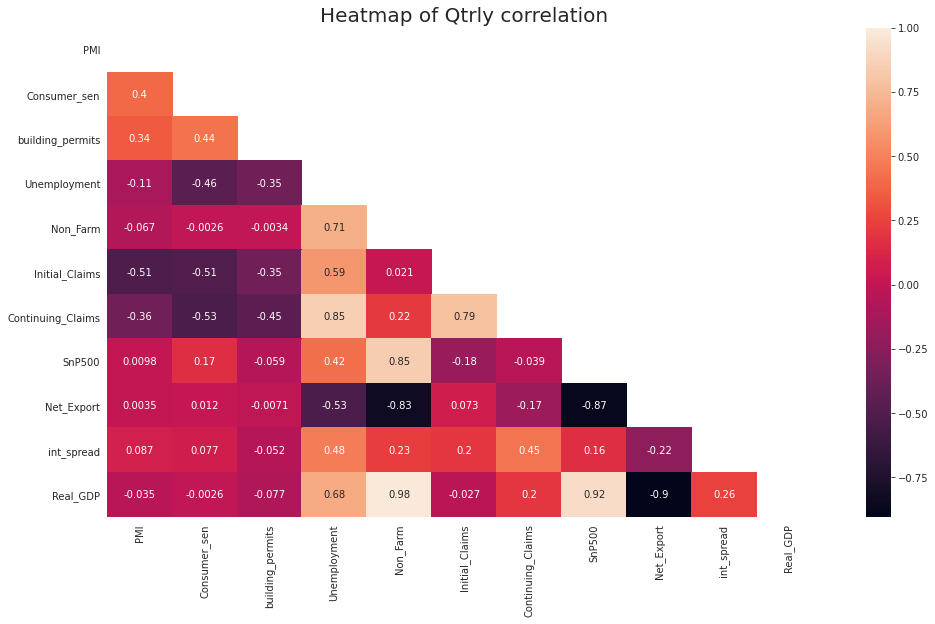

In [12]:
plt.figure(figsize=(16,9))

mask = np.zeros_like(df_qtr.corr())
#mask 
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(df_qtr.corr(),mask=mask, annot=True) 
    ax.set_title("Heatmap of Qtrly correlation", fontsize=20);

#### Decision: Drop all NA values (quarterly data from 1967-06-30-2020-03-31) 

In [13]:
dfq=df_qtr.dropna()

In [14]:
dfq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 1967-06-30 to 2020-03-31
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PMI                212 non-null    float64
 1   Consumer_sen       212 non-null    float64
 2   building_permits   212 non-null    float64
 3   Unemployment       212 non-null    float64
 4   Non_Farm           212 non-null    float64
 5   Initial_Claims     212 non-null    float64
 6   Continuing_Claims  212 non-null    float64
 7   SnP500             212 non-null    float64
 8   Net_Export         212 non-null    float64
 9   int_spread         212 non-null    float64
 10  Real_GDP           212 non-null    float64
dtypes: float64(11)
memory usage: 19.9 KB


In [15]:
dfq_diff=dfq.pct_change()

In [16]:
ss = StandardScaler()
scaled_dfq = ss.fit_transform(dfq_diff)
scaled_dfq = pd.DataFrame(scaled_dfq)
scaled_dfq.columns=dfq_diff.columns
scaled_dfq['Date']=dfq_diff.index
scaled_dfq.set_index('Date',inplace=True)

In [17]:
fig = go.Figure()

chart(scaled_dfq.index,scaled_dfq['PMI'],'PMI')
chart(scaled_dfq.index,scaled_dfq['Consumer_sen'],'Consumer_sentiment')
chart(scaled_dfq.index,scaled_dfq['building_permits'],'Building_permits')
chart(scaled_dfq.index,scaled_dfq['Unemployment'],'Unemployment')
chart(scaled_dfq.index,scaled_dfq['Non_Farm'],'Non_Farm')
chart(scaled_dfq.index,scaled_dfq['Initial_Claims'],'Initial_Claims')
chart(scaled_dfq.index,scaled_dfq['Continuing_Claims'],'Continuing_Claims')
chart(scaled_dfq.index,scaled_dfq['SnP500'],'S&P 500')
chart(scaled_dfq.index,scaled_dfq['Net_Export'],'Net Export')
chart(scaled_dfq.index,scaled_dfq['int_spread'],'Interest_spread')
chart(scaled_dfq.index,scaled_dfq['Real_GDP'],'Real_GDP')


# Edit the layout
fig.update_layout(title='Correlation of Quarterly Indexes',
                   xaxis_title='Period',
                   yaxis_title='% Change')

slider(fig)
fig.show()

In [18]:
fig = go.Figure()

chart(dfq.index,dfq['Real_GDP'],'Real_GDP')

slider(fig)

# Edit the layout
fig.update_layout(title='Quarterly Real US GDP',
                   xaxis_title='Period',
                   yaxis_title='Index')

fig.show()

#### - Monthly data

In [19]:
df=pd.read_csv('./Data/US.csv',parse_dates=['Date'],index_col='Date').drop('Unnamed: 0',axis=1)

In [20]:
df.head()

PMI  NMI  Consumer_sen  building_permits  Unemployment  Non_Farm  \
Date                                                                            
1948-02-29  50.2  NaN           NaN               NaN        2328.0   44533.0   
1948-03-31  43.3  NaN           NaN               NaN        2399.0   44683.0   
1948-04-30  45.4  NaN           NaN               NaN        2386.0   44379.0   
1948-05-31  49.5  NaN           NaN               NaN        2118.0   44796.0   
1948-06-30  53.0  NaN           NaN               NaN        2214.0   45034.0   

            Initial_Claims  Continuing_Claims     SnP500  VIX  Net_Export  \
Date                                                                        
1948-02-29             NaN                NaN  14.096667  NaN         NaN   
1948-03-31             NaN                NaN  14.284545  NaN       7.293   
1948-04-30             NaN                NaN  15.399091  NaN         NaN   
1948-05-31             NaN                NaN  16.171500  NaN         NaN   
1948-06-30             NaN                NaN  16.824545  NaN       5.205   

            int_spread  Real_GDP  GDP_Growth_Rate  
Date                                               
1948-02-29         NaN       NaN              NaN  
1948-03-31         NaN  2086.017              6.2  
1948-04-30         NaN       NaN              NaN  
1948-05-31         NaN       NaN              NaN  
1948-06-30         NaN  2120.450              6.8

#### Drop NMI , VIX columns in the monthly data

In [21]:
df=df.drop(["NMI",'VIX'],axis=1)

In [22]:
df.head()

PMI  Consumer_sen  building_permits  Unemployment  Non_Farm  \
Date                                                                       
1948-02-29  50.2           NaN               NaN        2328.0   44533.0   
1948-03-31  43.3           NaN               NaN        2399.0   44683.0   
1948-04-30  45.4           NaN               NaN        2386.0   44379.0   
1948-05-31  49.5           NaN               NaN        2118.0   44796.0   
1948-06-30  53.0           NaN               NaN        2214.0   45034.0   

            Initial_Claims  Continuing_Claims     SnP500  Net_Export  \
Date                                                                   
1948-02-29             NaN                NaN  14.096667         NaN   
1948-03-31             NaN                NaN  14.284545       7.293   
1948-04-30             NaN                NaN  15.399091         NaN   
1948-05-31             NaN                NaN  16.171500         NaN   
1948-06-30             NaN                NaN  16.824545       5.205   

            int_spread  Real_GDP  GDP_Growth_Rate  
Date                                               
1948-02-29         NaN       NaN              NaN  
1948-03-31         NaN  2086.017              6.2  
1948-04-30         NaN       NaN              NaN  
1948-05-31         NaN       NaN              NaN  
1948-06-30         NaN  2120.450              6.8

#### Data Imputation for Missing values

In [23]:
#https://tradingeconomics.com/united-states/consumer-confidence
df.loc[df.index=='2020-05-31','Consumer_sen']=72.3

In [24]:
# Drop the data before 1967-05-31 due to missing values
df=df[df.index >='1967-05-31']

In [25]:
df.tail()

PMI  Consumer_sen  building_permits  Unemployment  Non_Farm  \
Date                                                                       
2020-01-31  50.9          99.8            1536.0        5892.0  152212.0   
2020-02-29  50.1         101.0            1438.0        5787.0  152463.0   
2020-03-31  49.1          89.1            1356.0        7140.0  151090.0   
2020-04-30  41.5          71.8            1066.0       23078.0  130403.0   
2020-05-31  43.1          72.3            1220.0       20985.0  132912.0   

            Initial_Claims  Continuing_Claims       SnP500  Net_Export  \
Date                                                                     
2020-01-31        212750.0          1737750.0  3278.202857         NaN   
2020-02-29        211400.0          1703800.0  3277.314211         NaN   
2020-03-31       2666750.0          3497750.0  2652.393636    -526.154   
2020-04-30       5040250.0         17030250.0  2761.975238         NaN   
2020-05-31       2465800.0         22035000.0  2919.608500         NaN   

            int_spread   Real_GDP  GDP_Growth_Rate  
Date                                                
2020-01-31        0.21        NaN              NaN  
2020-02-29       -0.08        NaN              NaN  
2020-03-31        0.24  18974.702             -5.0  
2020-04-30        0.61        NaN              NaN  
2020-05-31        0.62        NaN              NaN

#### Filling in NaN via linear interpolation

In [26]:
df=df.interpolate(method='linear')

In [27]:
df=df[1:]

In [28]:
df.tail()

PMI  Consumer_sen  building_permits  Unemployment  Non_Farm  \
Date                                                                       
2020-01-31  50.9          99.8            1536.0        5892.0  152212.0   
2020-02-29  50.1         101.0            1438.0        5787.0  152463.0   
2020-03-31  49.1          89.1            1356.0        7140.0  151090.0   
2020-04-30  41.5          71.8            1066.0       23078.0  130403.0   
2020-05-31  43.1          72.3            1220.0       20985.0  132912.0   

            Initial_Claims  Continuing_Claims       SnP500  Net_Export  \
Date                                                                     
2020-01-31        212750.0          1737750.0  3278.202857 -560.629333   
2020-02-29        211400.0          1703800.0  3277.314211 -543.391667   
2020-03-31       2666750.0          3497750.0  2652.393636 -526.154000   
2020-04-30       5040250.0         17030250.0  2761.975238 -526.154000   
2020-05-31       2465800.0         22035000.0  2919.608500 -526.154000   

            int_spread      Real_GDP  GDP_Growth_Rate  
Date                                                   
2020-01-31        0.21  19139.547333        -0.266667  
2020-02-29       -0.08  19057.124667        -2.633333  
2020-03-31        0.24  18974.702000        -5.000000  
2020-04-30        0.61  18974.702000        -5.000000  
2020-05-31        0.62  18974.702000        -5.000000

### Using Facebook Prophet for US GDP prediction
- Prophet is open source software released by Facebook’s Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
- Prophet works best with time series that have strong seasonal effects and several seasons of historical data.
    - https://facebook.github.io/prophet/docs/non-daily_data.html
    - https://research.fb.com/prophet-forecasting-at-scale/ 
    - https://facebook.github.io/prophet/docs/quick_start.html#python-api
    
#!pip install fbprophet

#### Preparation of data for FB Prophet

In [29]:
dfq_fb=dfq.reset_index()
dfq_fb=dfq_fb[['Date','Real_GDP','PMI','Consumer_sen','building_permits','Unemployment','Non_Farm','Initial_Claims','Continuing_Claims','SnP500','Net_Export','int_spread']]
dfq_fb.columns=['ds','y','PMI','Consumer_sen','building_permits','Unemployment','Non_Farm','Initial_Claims','Continuing_Claims','SnP500','Net_Export','int_spread']
threshold=int(round(len(dfq_fb)*4.5/5,0))+1
train_90=dfq_fb.iloc[:threshold,:] #90/10 train_test_split 
dfq_fb_t= train_90.copy()
dfq_fb_t['date_index']=dfq_fb_t['ds']
dfq_fb_t.set_index('date_index',inplace=True)

In [30]:
dfq_fb_t.tail()

ds          y        PMI  Consumer_sen  building_permits  \
date_index                                                                    
2014-03-31 2014-03-31  16616.540  53.333333     80.933333       1027.333333   
2014-06-30 2014-06-30  16841.475  55.533333     82.833333       1039.333333   
2014-09-30 2014-09-30  17047.098  56.866667     82.966667       1066.666667   
2014-12-31 2014-12-31  17143.038  56.866667     89.766667       1074.333333   
2015-03-31 2015-03-31  17277.580  52.633333     95.500000       1084.333333   

            Unemployment       Non_Farm  Initial_Claims  Continuing_Claims  \
date_index                                                                   
2014-03-31  10310.333333  137743.333333   327153.846154       2.830615e+06   
2014-06-30   9673.666667  138547.000000   316461.538462       2.659692e+06   
2014-09-30   9489.666667  139297.333333   299769.230769       2.496077e+06   
2014-12-31   8932.333333  140101.333333   288538.461538       2.404385e+06   
2015-03-31   8666.333333  140772.333333   290692.307692       2.339692e+06   

                 SnP500  Net_Export  int_spread  
date_index                                       
2014-03-31  1834.871148    -506.318    2.690000  
2014-06-30  1900.372698    -507.643    2.530000  
2014-09-30  1975.908125    -492.266    2.406667  
2014-12-31  2009.344375    -524.406    2.180000  
2015-03-31  2063.689836    -532.532    1.856667

In [31]:
## Prepare for future values 
test_10=dfq_fb.iloc[threshold+1:,:]
dfq_fb_p=test_10 
dfq_fb_p=dfq_fb_p.drop('y',axis=1)
df_fb=df.reset_index()
df_fb=df_fb.drop(['Real_GDP','GDP_Growth_Rate'],axis=1)
df_fb=df_fb.tail(1)
df_fb['Date']=df_fb['Date']+ pd.offsets.QuarterEnd() #update the latest avail value to quarter
df_fb.rename(columns={'Date':'ds'},inplace=True)
dfq_fb_p=dfq_fb_p.append(df_fb)
dfq_fb_p.rename(columns={'ds':'future_date'},inplace=True)
dfq_fb_p.set_index('future_date',inplace=True)

In [32]:
def GDP_PMI(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['PMI'].values[0]
    else:
        return (dfq_fb_t[date:]['PMI']).values[0]
    
    return 0


def GDP_Consumer_sen(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Consumer_sen'].values[0]
    else:
        return (dfq_fb_t[date:]['Consumer_sen']).values[0]
    
    return 0


def GDP_building_permits(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['building_permits'].values[0]
    else:
        return (dfq_fb_t[date:]['building_permits']).values[0]
    
    return 0


def GDP_Unemployment(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Unemployment'].values[0]
    else:
        return (dfq_fb_t[date:]['Unemployment']).values[0]
    
    return 0


def GDP_Non_Farm(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Non_Farm'].values[0]
    else:
        return (dfq_fb_t[date:]['Non_Farm']).values[0]
    
    return 0

def GDP_Initial_Claims(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Initial_Claims'].values[0]
    else:
        return (dfq_fb_t[date:]['Initial_Claims']).values[0]
    
    return 0


def GDP_Continuing_Claims(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Continuing_Claims'].values[0]
    else:
        return (dfq_fb_t[date:]['Continuing_Claims']).values[0]
    
    return 0


def GDP_SnP500(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['SnP500'].values[0]
    else:
        return (dfq_fb_t[date:]['SnP500']).values[0]
    
    return 0


def GDP_Net_Export(ds):
    date = (pd.to_datetime(ds)).date()
    
    if dfq_fb_t[date:].empty:
        return dfq_fb_p[date:]['Net_Export'].values[0]
    else:
        return (dfq_fb_t[date:]['Net_Export']).values[0]
    
    return 0

In [33]:
# adding regressors is like adding features for modelling
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('PMI')
m.add_regressor('Consumer_sen')
m.add_regressor('building_permits')
m.add_regressor('Unemployment')
m.add_regressor('Non_Farm')
m.add_regressor('Initial_Claims')
m.add_regressor('Continuing_Claims')
m.add_regressor('SnP500')
m.add_regressor('Net_Export')
m.fit(dfq_fb_t)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods=len(dfq_fb_p)+1, freq='q')
future['PMI'] = future['ds'].apply(GDP_PMI)
future['Consumer_sen'] = future['ds'].apply(GDP_Consumer_sen)
future['building_permits'] = future['ds'].apply(GDP_building_permits)
future['Unemployment'] = future['ds'].apply(GDP_Unemployment)
future['Non_Farm'] = future['ds'].apply(GDP_Non_Farm)
future['Initial_Claims'] = future['ds'].apply(GDP_Initial_Claims)
future['Continuing_Claims'] = future['ds'].apply(GDP_Continuing_Claims)
future['SnP500'] = future['ds'].apply(GDP_SnP500)
future['Net_Export'] = future['ds'].apply(GDP_Net_Export)

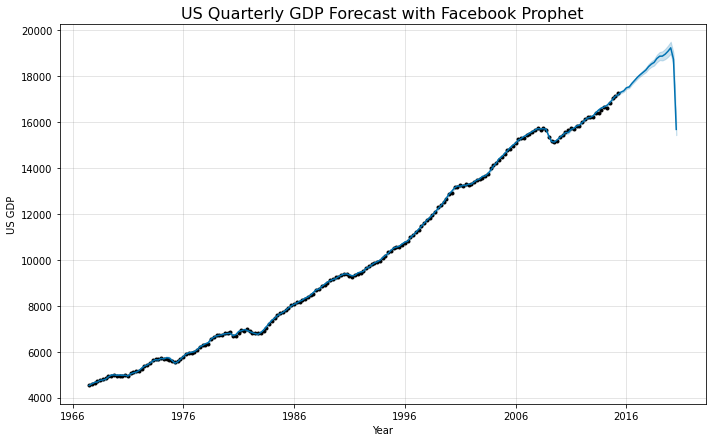

In [35]:
forecast = m.predict(future)
fig = m.plot(forecast)

plt.title('US Quarterly GDP Forecast with Facebook Prophet', size=16);
plt.xlabel('Year');
plt.ylabel('US GDP');

In [36]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper
203 2018-03-31  18520.813002  18399.405714  18645.704716
204 2018-06-30  18595.511480  18456.395489  18736.800415
205 2018-09-30  18766.441494  18600.388360  18932.037005
206 2018-12-31  18865.826781  18696.490429  19052.600630
207 2019-03-31  18870.445698  18678.506344  19080.300768
208 2019-06-30  18954.076188  18738.113607  19185.197819
209 2019-09-30  19078.148762  18836.070564  19327.669003
210 2019-12-31  19231.449194  18969.142342  19500.566539
211 2020-03-31  18731.336705  18449.204558  19019.621723
212 2020-06-30  15680.017419  15427.100562  15950.479839

In [37]:
dfq['Real_GDP'].tail(10)

Date
2017-12-31    18322.464
2018-03-31    18438.254
2018-06-30    18598.135
2018-09-30    18732.720
2018-12-31    18783.548
2019-03-31    18927.281
2019-06-30    19021.860
2019-09-30    19121.112
2019-12-31    19221.970
2020-03-31    18974.702
Name: Real_GDP, dtype: float64

In [38]:
actual=dfq[['Real_GDP']].reset_index()

In [40]:
fb_prophet=forecast[['ds', 'yhat']]

In [41]:
# Merging the predicted value against the actual value
fbcompare=pd.merge(fb_prophet,actual,left_on='ds',right_on='Date',how='left').drop('Date',axis=1).set_index('ds')

In [42]:
fbcompare.tail(10)

yhat   Real_GDP
ds                                 
2018-03-31  18520.813002  18438.254
2018-06-30  18595.511480  18598.135
2018-09-30  18766.441494  18732.720
2018-12-31  18865.826781  18783.548
2019-03-31  18870.445698  18927.281
2019-06-30  18954.076188  19021.860
2019-09-30  19078.148762  19121.112
2019-12-31  19231.449194  19221.970
2020-03-31  18731.336705  18974.702
2020-06-30  15680.017419        NaN

In [43]:
fig = go.Figure()

chart(fbcompare.index,fbcompare['yhat'],'Predicted')
chart(fbcompare.index,fbcompare['Real_GDP'],'Actual')
slider(fig)

# Edit the layout
fig.update_layout(title='Compare Actual Quarterly Real US GDP vs FB Prophet',
                   xaxis_title='Period',
                   yaxis_title='GDP')

fig.show()

### Observation: Predicted Q2 2020 US GDP by FB Prophet

- FB Prophet predicted Q2 2020 to drop to 15,601 (~15% drop from previou quarter).
- It is comparable to the analysis by Deloitte Analysis published on 15 Jun 2020. 

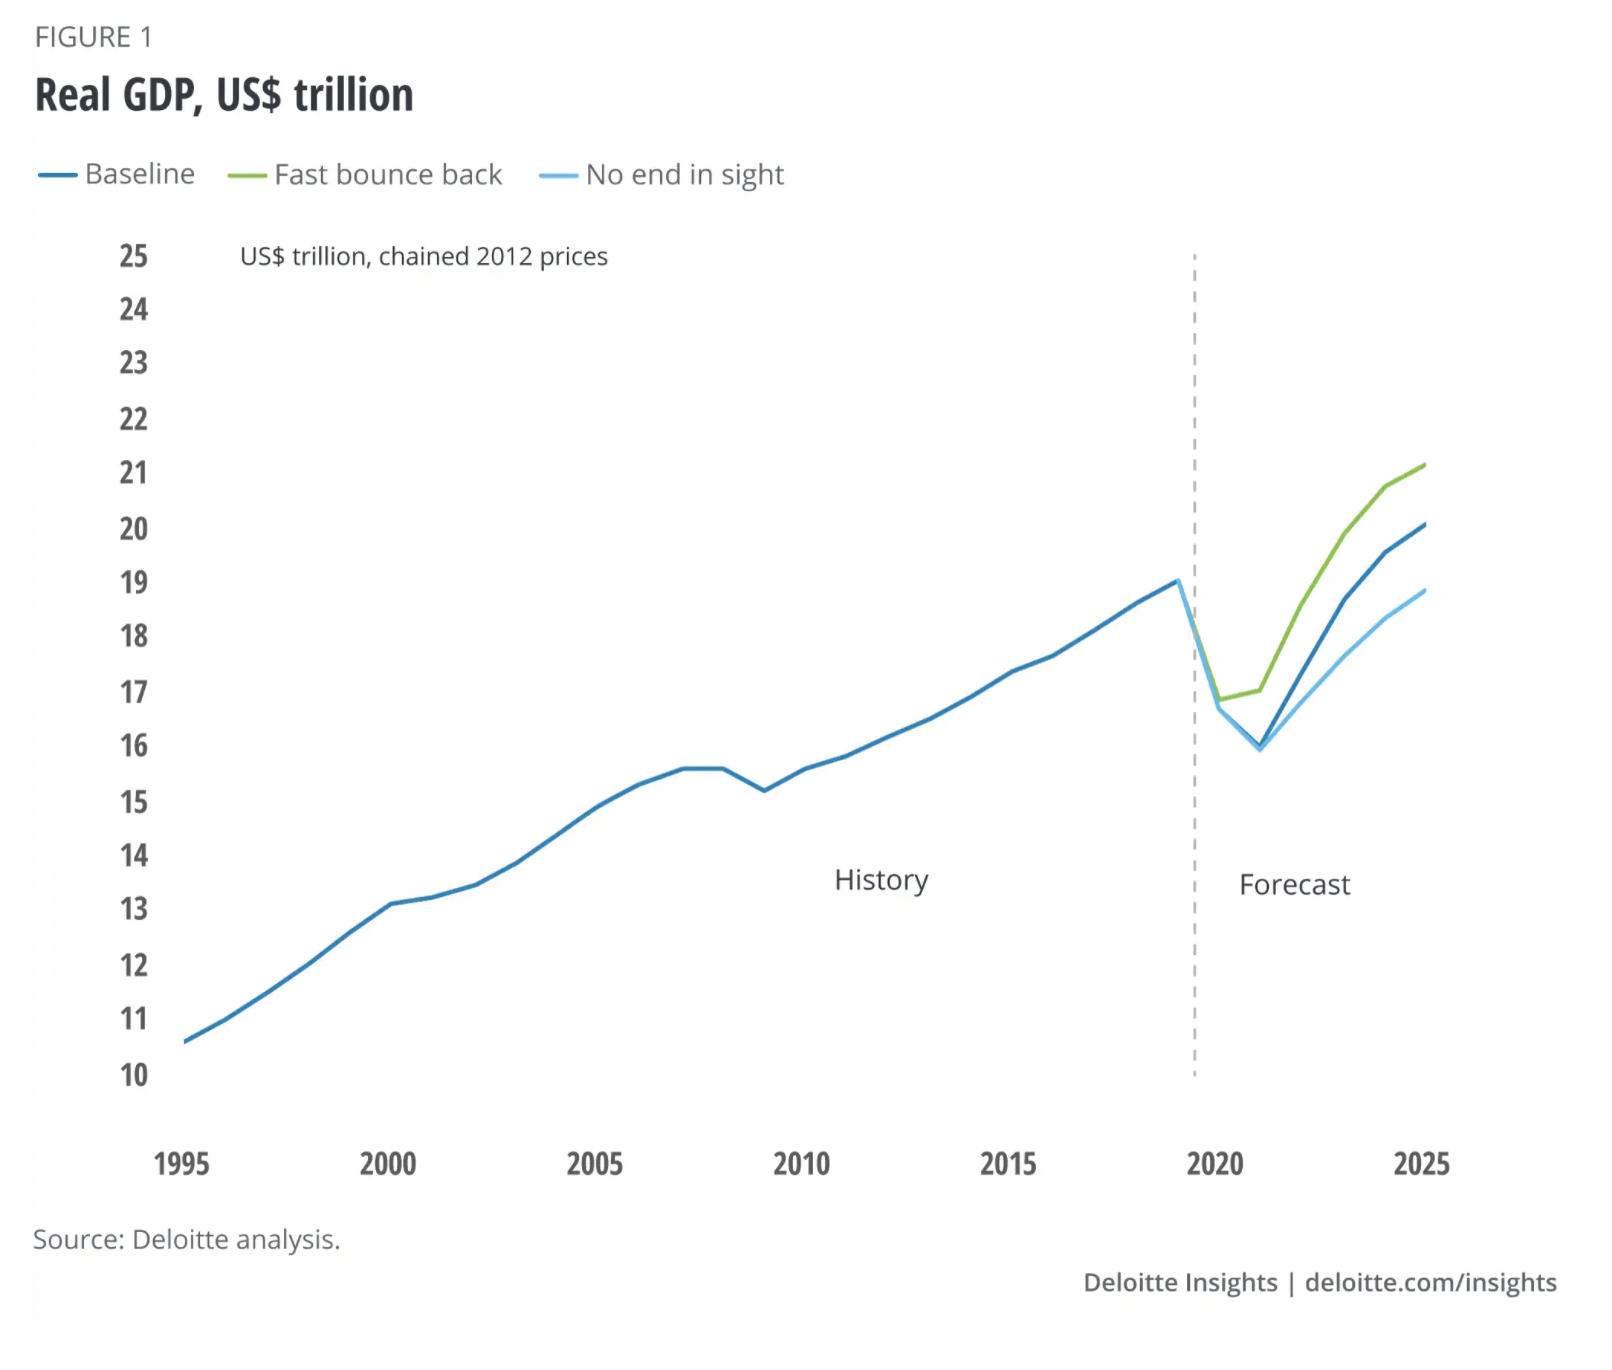
https://www2.deloitte.com/us/en/insights/economy/us-economic-forecast/united-states-outlook-analysis.html